In [40]:
%load_ext autoreload
%autoreload 2
from __future__ import absolute_import

#check if there is an evirronment variable called ROOT_PATH
import os
if 'ROOT_PATH' in os.environ:
    ROOT_PATH = os.environ['ROOT_PATH']
else:
    ROOT_PATH = '/homes/ar2342/one_more_dir/contextual_frogs/'
    os.environ['ROOT_PATH'] = ROOT_PATH
    
import sys
sys.path.append(ROOT_PATH)

# import local_settings
import importlib

from copy import copy

import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim

from types import SimpleNamespace

import matplotlib.pyplot as plt
from models import MLP, OneOverSqr
from dsp_utils import seg_time
from siggen_utils import herzfeld_block
from plt_utils import plot_by_key,plot_segments

from dsp_utils import parse_samples
from autoreg_utils import clnn_kalman_matrix_prep

from runners import Runner
# from custom_optimizers import ElementWiseDecay, GlobalPNormDecay

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [41]:
P0=0
Pplus=1
Pminus=-1
Pchannel=np.nan

TfN1 = 100
TfA = 400
TfN2 = 300

TsN=60
TsA=120
TsB=20
TsC=20

# T=300
TaN=150
TaB=120

# playlist_ab = {
# 'AB0':[(P0, TaN),(Pminus, TaB)],
# 'AB1':[(P0, TaN),(Pplus,13),(Pminus, TaB)],
# 'AB2':[(P0, TaN),(Pplus,41),(Pminus, TaB)],
# 'AB3':[(P0, TaN),(Pplus,112),(Pminus, TaB)],
#      }

playlist = {
# 'frogs': [(P0,TfN1),((P0,Pplus),TfA),(P0,TfN2)],
# 'anti_frogs': [(P0,TfN1),(Pplus,TfA),(P0,TfN2)],
# 'savings': 2 * [(P0, TsA), (Pplus, TsA)], #, (Pminus, TsB), (Pchannel, TsC)],
# 'savings': [(P0, TsA), (Pplus, TsA),(P0, 2000),(Pplus, TsA)], #, (Pminus, TsB), (Pchannel, TsC)],
# 'savings': 2 * [(P0, TsN), (Pplus, TsA), (Pminus, TsB), (Pchannel, TsC)],
'sprecovery': [(P0, 30), (Pplus, 30)],
# 'evrecovery': [(P0, 50),
#                (Pplus, 120),
#                (Pminus, 15),
#                (Pchannel, 2),
#                (Pplus, 2),
#                (Pchannel, 140)],
# 'spOVRrecovery': [(P0, 50),
#                (Pplus, 450),
#                (Pminus, 15),
#                (Pchannel, 140)],
# 'spOVRrecovery_ref': [(P0, 50),
#                (Pplus, 150),
#                (Pminus, 15),
#                (Pchannel, 140)],
# 'lng_recovery': [(P0, 192),
#                (Pplus, 384),
#                (Pminus, 384),
#                (Pchannel, 400)],    
# 'ANB0':[(P0, TaN),(Pminus, TaB)],
# 'ANB1':[(P0, TaN),(Pplus,13),(P0, TaB),(Pminus, TaB)],
# 'ANB2':[(P0, TaN),(Pplus,41),(P0, TaB),(Pminus, TaB)],
# 'ANB3':[(P0, TaN),(Pplus,112),(P0, TaB),(Pminus, TaB)],
    }

# playlist.update(playlist_ab)

# def generate_herzfeld_scenarios(z_list=None, n_blocks=None, Tflips=None): 
#     out_dict = {}
#     for z in z_list:
#         scenario_name =  f'herzfeld,z={z}'
#         pert_per_z = []
#         for n in range(n_blocks):
#             hz = herzfeld_block(z, P1=Pplus,P2=Pminus,P0=P0, tau=1)
#             pert_per_z.append((hz,len(hz)))
#         out_dict.update({scenario_name:pert_per_z})
#     return out_dict

# hrz_params = {'z_list': [0.1,0.5,0.9], 'n_blocks': 25}
# playlist.update(generate_herzfeld_scenarios(**hrz_params))
        

In [42]:
# frog_playlist = {
# f'frogs{f}': [(P0,TfN1),((P0,Pplus),TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])}

# frog_playlist_a = {
# f'anti_frogs{f}': [(P0,TfN1),(Pplus,TfA_),(P0,TfN2)] for f,TfA_ in enumerate([300,600, 900])} 

# frog_playlist.update(frog_playlist_a)

In [43]:
from dsp_utils import parse_samples

In [44]:
stimulus_np = parse_samples(playlist['sprecovery'])

In [45]:
test_vec= np.stack([np.zeros(200),
                    np.zeros(200),
                    np.zeros(200),
                   np.linspace(2*Pminus,2*Pplus,200)]).T

x_test = test_vec[:,-1]
n_grid = 11
x_grid =  np.stack([np.zeros(n_grid),
                    np.zeros(n_grid),
                    np.zeros(n_grid),
                   np.linspace(1.2*Pminus,1.2*Pplus,n_grid)]).T

In [46]:
cnt =0
n_realizations = 2000
results = {}
swarg1s = [
    {'noi_x': 0.0, 'noi_u': 0.0, 'noi_y': 0.0, 'noi_post_u': 0.0}] +[
    # {'noi_x': 0.05, 'noi_u': 0.1, 'noi_y': 0.05, 'noi_post_u': 0.1},
    {'noi_x': 0.00, 'noi_u': 0.3, 'noi_y': 0.00, 'noi_post_u': 0.01},
] * n_realizations
swarg2s =  [1e-3] #[0.05,0.1,0.2,0.5,1,2]
for i1, swarg1 in enumerate(swarg1s):
    for i2, swarg2 in enumerate(swarg2s):
        lr = swarg2
        b_high = 0.2
        noise_spec = swarg1
        beta = None
        model_construct_args =  dict(n_inputs = 4,
                          n_hidden = 2*512,
                          n_outs = 1,
                          en_bias = False,
                         b_high=b_high, first_layer_init='uniform_unity',
                        first_layer_weights_trainable = False,
                        out_layer_init='zeros',
                        post_activation_bias = None,
                        post_activation_bias_scale = 0,
                          nl = 'relu', skip_gain= 0)
        setting = {'criterion':'MSE', 'k':[0,0,0,1], 'learning_rate':lr, 'sigma_noi':0.0, 'tau_u':1,'enable_combo':True, 'noise_spec':noise_spec,
        'take_lin_measurements': i1==0, 'lin_measurement_opts': {'x_grid': x_grid}}
        runner = Runner(model_construct_args=model_construct_args,
                        test_vec=test_vec,
                        **setting)
        results[(i1,i2)] = runner.run_multiple(playlist)
        if i1 == 0:
            stepwise_lin_data = runner._stepwise_recorder.copy()
            initial_lin_data = runner._initial_recordings.copy()

running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenario: sprecovery
running scenar

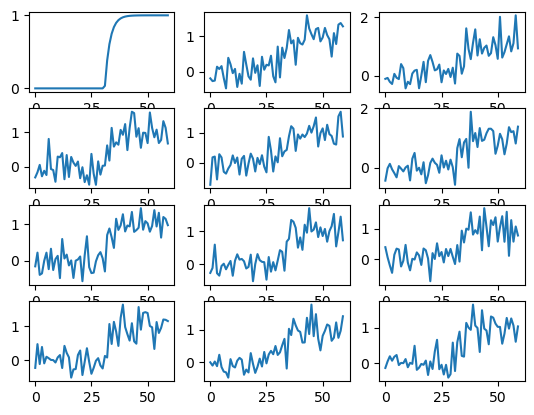

In [47]:
for i, _ in enumerate(swarg1s):
    these_results = results[i,0]
    plt.subplot(4, 3, i+1)
    plt.plot(these_results['sprecovery'].u_lp)
    if i ==11:
        break

In [48]:
def list_of_dicts_to_dict_of_lists(list_of_dicts):
    out_dict = {}
    for d in list_of_dicts:
        for k,v in d.items():
            if k not in out_dict:
                out_dict[k] = []
            out_dict[k].append(v)
    return out_dict

In [49]:
per_step_data = list_of_dicts_to_dict_of_lists(stepwise_lin_data)

In [50]:
per_step_data.keys()

dict_keys(['e', 'u', 'y', 'x', 'Jx', 'lr'])

In [51]:
for kk in ['x', 'Jx']:
    per_step_data[kk]  = [foo.squeeze()[-1] if  isinstance(foo,np.ndarray) else foo for foo in per_step_data[kk]]


In [52]:
initial_lin_data['K'].shape, initial_lin_data['H'].shape

((11, 11), (11, 11, 4))

In [53]:
per_episode_data = initial_lin_data.copy()
per_episode_data['H'] = per_episode_data['H'][:,:,-1]
per_episode_data['alpha'] = 2*lr

In [54]:
per_episode_data['gamma'] = 1.0

In [55]:
per_episode_data['K'].shape, per_episode_data['H'].shape

((11, 11), (11, 11))

In [56]:
opts = {'compute_lambda': True, 'x_grid': x_grid[:,-1]}

In [57]:
ref_noise_cond_id = 0
noise_cond_id = 2

duu = np.array(results[noise_cond_id,0]['sprecovery'].u_lp) - np.array(results[ref_noise_cond_id,0]['sprecovery'].u_lp)

s = this_noise_spec = swarg1s[noise_cond_id]
_p = per_episode_data

In [58]:
per_step_data['trial_type'] = [np.logical_not(np.isnan(foo)) for foo in stimulus_np]

In [59]:
per_step_data['bbar_e'] = per_step_data.pop('e')



In [60]:
# per_step_data = {k: v[1:] for k, v in per_step_data.items()}

In [61]:
per_step_data.keys()

dict_keys(['u', 'y', 'x', 'Jx', 'lr', 'trial_type', 'bbar_e'])

In [62]:
from stat_utils import run_trial

In [63]:


ref_noise_cond_id = 0
oos = []
duus =[]
for cc, noise_cond_id in enumerate(range(1, len(swarg1s))):
  

  duu = np.array(results[noise_cond_id,0]['sprecovery'].u_lp) - np.array(results[ref_noise_cond_id,0]['sprecovery'].u_lp)

  s = this_noise_spec = swarg1s[noise_cond_id]
  _p = per_episode_data
  epsilon = 1e-9
  _p['sigma_u'], _p['sigma_y'], _p['sigma_x'], _p['sigma_a'] = s['noi_u']+epsilon, s['noi_y']+epsilon, s['noi_x']+epsilon, s['noi_post_u']+epsilon

  # print('per episode data', per_episode_data)
  kalman_params = clnn_kalman_matrix_prep( {'fixed': per_episode_data,
                                          'time_varying': per_step_data},
                                        timestep=None,
                                        opts=opts)
  oo = run_trial(kalman_params,
                  sim_data=duu.reshape(1,-1), #convention in kalman filter that observation and states are column vectors
                  sim_params=None, 
                  Tmax=len(stimulus_np), 
                  discard_1st_step_stats=False)
  oos.append(oo.copy())
  duus.append(duu.copy())
  # plt.subplot(2, 3, cc+1)
  # plt.plot(results[noise_cond_id,0]['sprecovery'].u_lp)
  # plt.plot(results[ref_noise_cond_id,0]['sprecovery'].u_lp)
  # plt.plot(results[ref_noise_cond_id,0]['sprecovery'].u_lp+oo['z_pred'][0,:])
# plt.plot(results[ref_noise_cond_id,0]['sprecovery'].u_lp+oo['][0,:])

In [64]:
np.shape(duus)
# for cc, oo in enumerate(oos):
#     plt.subplot(2, 3, cc+1)
#     err_kalman = duus[cc]  - oo['z_pred'][0,:]
     
#     plt.plot(err_kalman)
#     plt.text(0, -0.20, f"RMSE : {np.sqrt(np.mean(err_kalman**2)):.3f}, \n err_uu: {np.sqrt(np.mean(duus[cc]**2)):.3f}")

(2000, 60)

In [65]:
full_ll = 0
for oo in oos:
    # print(oo['total_ll'])
    full_ll += oo['total_ll']

In [66]:
ll_traj = np.array([oo['lls'] for oo in oos])

In [67]:
#compute total covariance
cov = 0
for duu in duus:
    cov += duu.reshape(-1,1) @ duu.reshape(1,-1)
cov /= len(duus)

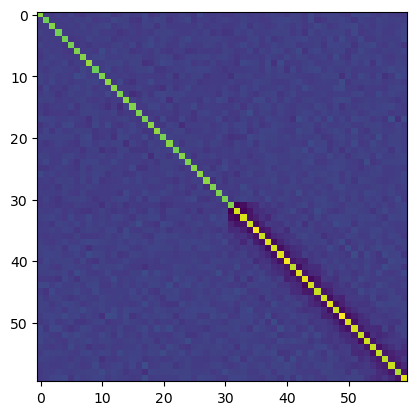

In [68]:
plt.imshow(cov)

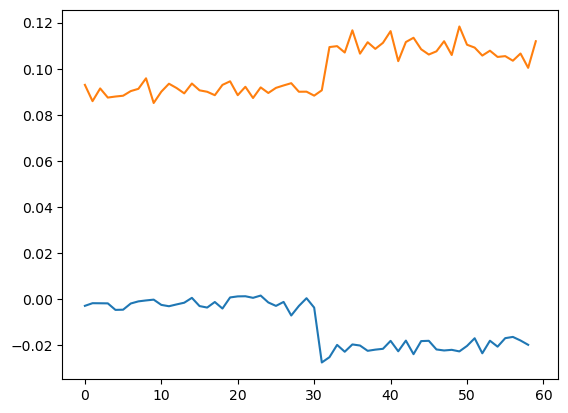

In [69]:
plt.plot(np.diag(cov,1))
plt.plot(np.diag(cov,0))

In [70]:
from stat_utils import multivar_entropy
print(f"Covariance entropy: {multivar_entropy(cov):.3f}")

m: 60, logdet: -144.86749747368066
Covariance entropy: 12.703


In [71]:
full_ll/len(duus)

-18.263495643089833

In [72]:
ll_traj.mean(axis=0)

array([-0.9654806 , -0.98995486, -0.51663021, -0.39341947, -0.34117638,
       -0.32054728, -0.3059927 , -0.29014043, -0.30125461, -0.24186646,
       -0.25270213, -0.2720949 , -0.26317217, -0.24477831, -0.27161362,
       -0.26148548, -0.25550159, -0.23536867, -0.25268696, -0.26520264,
       -0.22462186, -0.24941429, -0.22979311, -0.24277153, -0.22673949,
       -0.24674499, -0.24606354, -0.25246504, -0.23474984, -0.23179907,
       -0.21862001, -0.87001389, -0.51409877, -0.416259  , -0.34480982,
       -0.35276016, -0.28802312, -0.29751456, -0.27599861, -0.28039436,
       -0.29414464, -0.24046139, -0.25939292, -0.27938763, -0.24573438,
       -0.21376375, -0.2511682 , -0.25916886, -0.22301359, -0.27337458,
       -0.235024  , -0.23048051, -0.23659003, -0.21279417, -0.2371861 ,
       -0.21803372, -0.2156657 , -0.22211333, -0.19337913, -0.23789444])

In [73]:
ll_traj.mean(axis=0)[10:].sum()

-13.597032632306709

In [74]:
vars_from_kf = np.array([oo['var_z_pred'] for oo in oos]).squeeze().mean(axis=0)
print(vars_from_kf)

[1.0001     1.06311423 0.17256145 0.13315454 0.11923231 0.11211369
 0.10779075 0.10488689 0.10280188 0.10123216 0.10000771 0.09902591
 0.09822112 0.09754944 0.09698037 0.09649206 0.09606846 0.09569751
 0.09536996 0.09507862 0.0948178  0.09458294 0.09437035 0.09417701
 0.09400041 0.09383847 0.09368944 0.09355184 0.09342439 0.09330602
 0.09319578 0.81357543 0.17017068 0.13247396 0.11890988 0.11192525
 0.10766829 0.10480289 0.10274308 0.1011914  0.09998078 0.09901016
 0.09821481 0.09755137 0.09698969 0.09650815 0.09609085 0.09572584
 0.09540396 0.09511807 0.09486252 0.09463279 0.09442522 0.09423678
 0.09406501 0.09390783 0.0937635  0.09363053 0.09350768 0.09339385]


In [75]:
print(f"Covariance entropy: {multivar_entropy(cov[10:,10:]):.3f}")
print(f"Covariance entropy from diag: {multivar_entropy(np.diag(vars_from_kf[10:])):.3f}")


m: 50, logdet: -120.29977619144199
Covariance entropy: 10.797
m: 50, logdet: -113.6813637836684
Covariance entropy from diag: 14.106


In [76]:
oos[0]['var_z_pred']

[array([[1.0001]]),
 array([[1.06311423]]),
 array([[0.17256145]]),
 array([[0.13315454]]),
 array([[0.11923231]]),
 array([[0.11211369]]),
 array([[0.10779075]]),
 array([[0.10488689]]),
 array([[0.10280188]]),
 array([[0.10123216]]),
 array([[0.10000771]]),
 array([[0.09902591]]),
 array([[0.09822112]]),
 array([[0.09754944]]),
 array([[0.09698037]]),
 array([[0.09649206]]),
 array([[0.09606846]]),
 array([[0.09569751]]),
 array([[0.09536996]]),
 array([[0.09507862]]),
 array([[0.0948178]]),
 array([[0.09458294]]),
 array([[0.09437035]]),
 array([[0.09417701]]),
 array([[0.09400041]]),
 array([[0.09383847]]),
 array([[0.09368944]]),
 array([[0.09355184]]),
 array([[0.09342439]]),
 array([[0.09330602]]),
 array([[0.09319578]]),
 array([[0.81357543]]),
 array([[0.17017068]]),
 array([[0.13247396]]),
 array([[0.11890988]]),
 array([[0.11192525]]),
 array([[0.10766829]]),
 array([[0.10480289]]),
 array([[0.10274308]]),
 array([[0.1011914]]),
 array([[0.09998078]]),
 array([[0.09901016]])

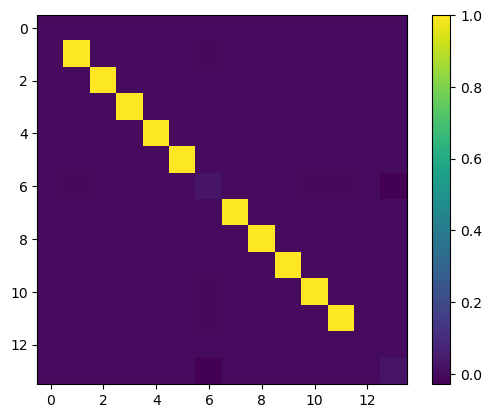

In [77]:
plt.imshow(oos[0]['Ps'][3])
plt.colorbar()

ValueError: num must be an integer with 1 <= num <= 6, not 7

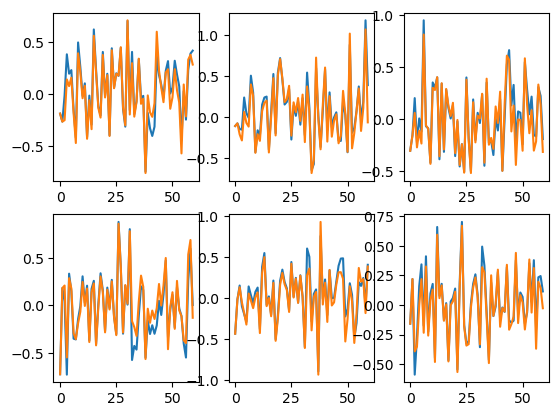

In [78]:
for cc, oo in enumerate(oos):
    plt.subplot(2, 3, cc+1)
    err_kalman = duus[cc] - oo['z_pred'][0,:]
     
    plt.plot(err_kalman)
    plt.plot(duus[cc])
    # plt.text(0, -0.20, f"RMSE : {np.sqrt(np.mean(err_kalman**2)):.3f}, err_uu: {np.sqrt(np.mean(duus[cc]**2)):.3f}")

In [83]:
multivar_entropy(np.eye(1)), multivar_entropy(0.01*np.eye(1))

m: 1, logdet: 0.0
m: 1, logdet: -4.605170185988091


(1.4189385332046727, -0.8836465597893728)

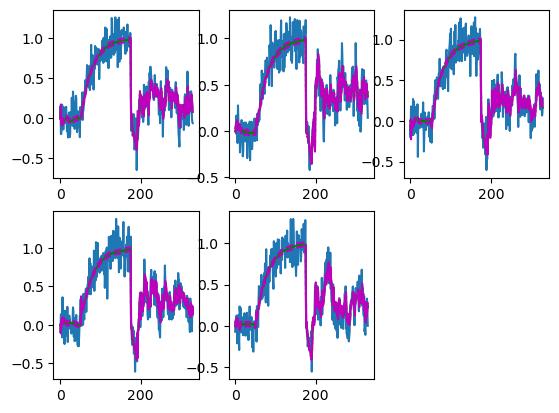

In [ ]:
for cc, noise_cond_id in enumerate(range(1, len(swarg1s))):
    plt.subplot(2, 3, cc+1)
    plt.plot(results[noise_cond_id,0]['sprecovery'].u_lp)
    plt.plot(results[ref_noise_cond_id,0]['sprecovery'].u_lp+oos[cc]['z_pred'][0,:],'g')
    plt.plot(results[ref_noise_cond_id,0]['sprecovery'].u_lp+oos[cc]['z_pred'][0,:]+oos[cc]['sigma_z_pred'][0,:],'m--')
    plt.plot(results[ref_noise_cond_id,0]['sprecovery'].u_lp+oos[cc]['z_pred'][0,:]-oos[cc]['sigma_z_pred'][0,:],'m--')

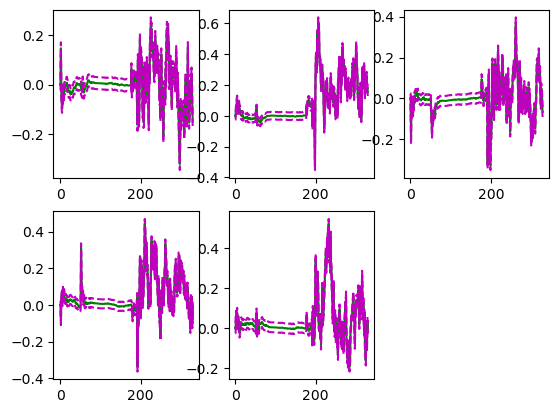

In [ ]:
for cc, noise_cond_id in enumerate(range(1, len(swarg1s))):
    plt.subplot(2, 3, cc+1)
    # plt.plot(results[noise_cond_id,0]['sprecovery'].u_lp)
    plt.plot(oos[cc]['z_pred'][0,:],'g')
    plt.plot(oos[cc]['z_pred'][0,:]+oos[cc]['sigma_z_pred'][0,:],'m--')
    plt.plot(oos[cc]['z_pred'][0,:]-oos[cc]['sigma_z_pred'][0,:],'m--')

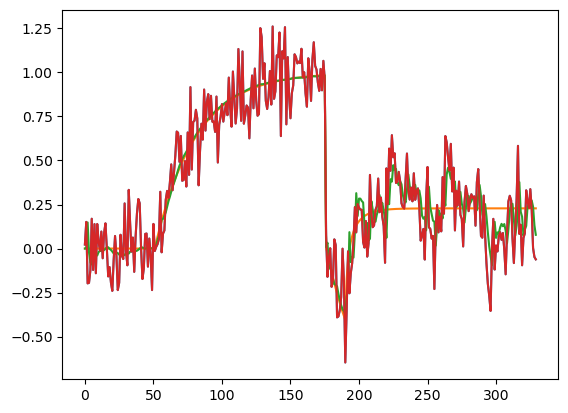

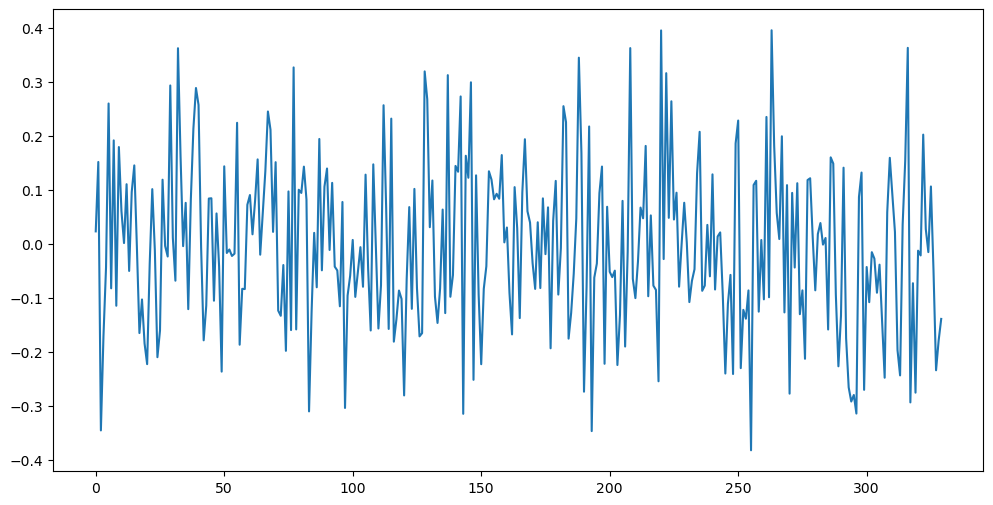

In [ ]:
for cc, noise_cond_id in [(0,1)]: #enumerate(range(1, len(swarg1s))):
    plt.plot(results[noise_cond_id,0]['sprecovery'].u_lp)
    plt.plot(results[ref_noise_cond_id,0]['sprecovery'].u_lp)
    plt.plot(results[ref_noise_cond_id,0]['sprecovery'].u_lp+oos[cc]['z_pred'][0,:])
    plt.plot(results[ref_noise_cond_id,0]['sprecovery'].u_lp+duus[cc])
    plt.figure(figsize=(12, 6))
    err_kalman = duus[cc] - oos[cc]['z_pred'][0,:]
    plt.plot(err_kalman)



In [ ]:
this_cc = -2
this_oo = oos[this_cc]

s = this_noise_spec = swarg1s[this_cc]
_p = per_episode_data
epsilon = 1e-9
_p['sigma_u'], _p['sigma_y'], _p['sigma_x'], _p['sigma_a'] = s['noi_u']+epsilon, s['noi_y']+epsilon, s['noi_x']+epsilon, s['noi_post_u']+epsilon


kalman_params = clnn_kalman_matrix_prep( {'fixed': per_episode_data,
                                        'time_varying': per_step_data},
                                    timestep=None,                           
                                    opts=opts)


In [ ]:
np.max(this_oo['s_est']), np.argmax(this_oo['s_est'])
tspur = np.argmax(this_oo['s_est'])%this_oo['s_est'].shape[1]

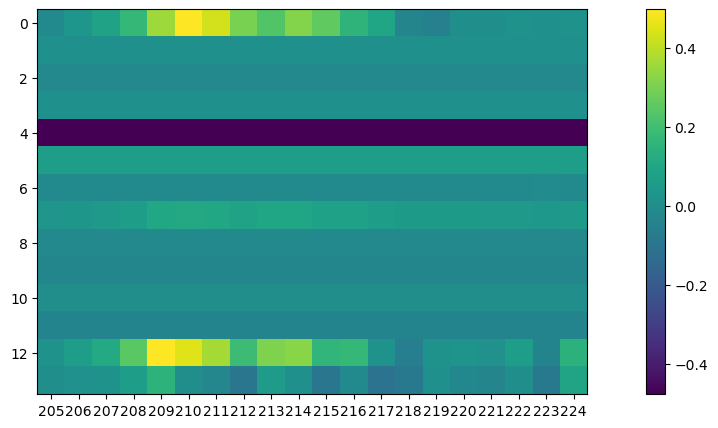

In [ ]:
plt.figure(figsize=(15, 5))
plt.imshow(this_oo['s_est'][:,tspur-5:tspur+15])
plt.xticks(np.arange(0, 20, 1), np.arange(tspur-5, tspur+15, 1))
plt.colorbar()

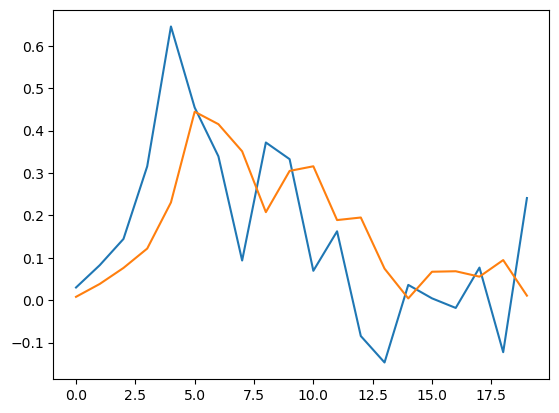

In [ ]:
plt.plot(duus[this_cc][tspur-5:tspur+15].T)
plt.plot(this_oo['z_pred'][0,tspur-5:tspur+15])

In [ ]:
this_oo['s_est'][:,tspur-1]

array([ 0.35622779,  0.01041105, -0.01931419,  0.01056953, -0.47757507,
        0.06723775, -0.01331921,  0.10801316, -0.01979953, -0.0293319 ,
        0.0055818 , -0.03949456,  0.49471649,  0.15092711])

In [ ]:
this_oo['s_est'][:,tspur]

array([ 0.49730051,  0.01041205, -0.01931009,  0.01057   , -0.47759244,
        0.06727118, -0.01336627,  0.10889667, -0.01980287, -0.0293372 ,
        0.00558147, -0.03950237,  0.4507739 ,  0.00359147])

In [ ]:
from stat_utils import kalman_step

In [ ]:
this_step = kalman_step(this_oo['s_est'][:,tspur-1].reshape(-1,1),
            P_tm1=this_oo['Ps'][tspur-1],
            z_t=duus[this_cc][tspur].reshape(-1,1),
            F=kalman_params['F'][tspur],
            H=kalman_params['H'][tspur],
            Q=kalman_params['Q'][tspur],
            R=kalman_params['R'][tspur],)
np.vstack((this_step[3].squeeze(), this_oo['s_est'][:,tspur]))

array([[ 0.49730051,  0.01041205, -0.01931009,  0.01057   , -0.47759244,
         0.06727118, -0.01336627,  0.10889667, -0.01980287, -0.0293372 ,
         0.00558147, -0.03950237,  0.4507739 ,  0.00359147],
       [ 0.49730051,  0.01041205, -0.01931009,  0.01057   , -0.47759244,
         0.06727118, -0.01336627,  0.10889667, -0.01980287, -0.0293372 ,
         0.00558147, -0.03950237,  0.4507739 ,  0.00359147]])

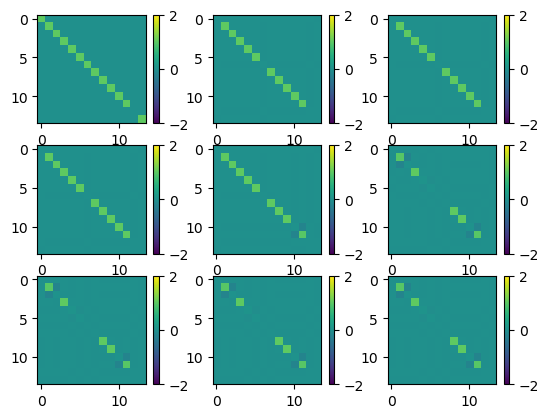

In [ ]:
for ii,ix in enumerate([0,1,10,50, 80, tspur-10,tspur-1, tspur, tspur+1]):
    plt.subplot(3, 3, ii+1)

    plt.imshow(this_oo['Ps'][ix], vmax=2,vmin=-2)
    plt.colorbar()

In [ ]:
np.max(kalman_params['Q'][1])

0.010000004878578661

In [ ]:
import pandas as pd

Text(0, 0.5, 'log-likelihood from empirical covariance (entropy)')

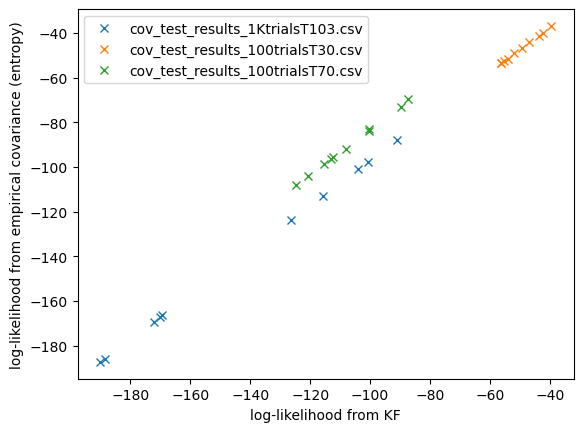

In [ ]:
#load csv
files = [('cov_test_results_1KtrialsT103.csv',1000 ),
         ('cov_test_results_100trialsT30.csv',100),
         ('cov_test_results_100trialsT70.csv',100),]
for f, trials in files:
    df = pd.read_csv(ROOT_PATH + f)
    plt.plot(df['LL_filt']/trials,df['LL_entropy']/trials,'x', label=f"{f}")
plt.legend()
plt.xlabel('log-likelihood from KF')
plt.ylabel('log-likelihood from empirical covariance (entropy)')

In [ ]:
plt.plot(df[])